In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from tqdm.auto import trange, tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
dataset = torchvision.datasets.FashionMNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

100%|██████████| 26421880/26421880 [00:11<00:00, 2311977.44it/s]


Extracting mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209502.61it/s]


Extracting mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3903071.99it/s]


Extracting mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24991061.33it/s]

Extracting mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



In [4]:
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([6, 9, 2, 7, 0, 2, 4, 0])


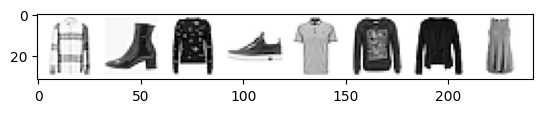

In [5]:
x, y = next(iter(train_loader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [6]:
def corrupt_image(x, noise_level):
    noise_level = noise_level.view(-1, 1, 1, 1)
    return torch.randn_like(x) * noise_level + x * (1 - noise_level)

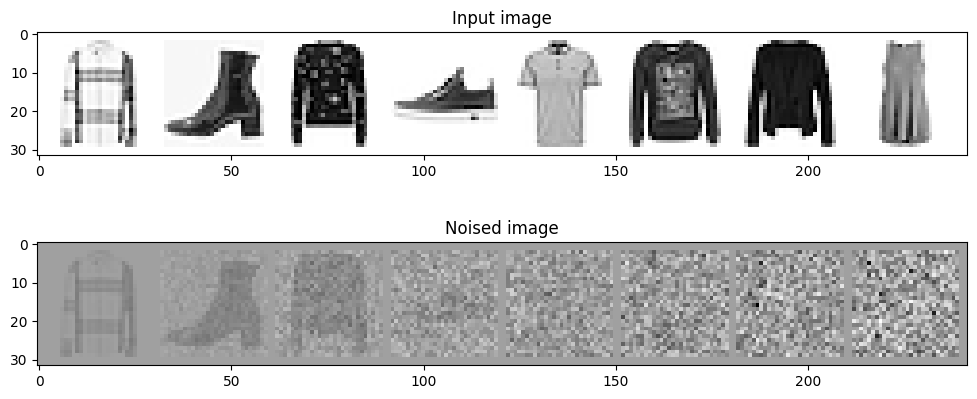

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input image")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

noise_level = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt_image(x, noise_level)

axs[1].set_title("Noised image")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2)
            ]
        )
        self.downscale = nn.MaxPool2d(2)
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
            ]
        )
        self.upscale = nn.Upsample(scale_factor=2)
        self.act = nn.SiLU()

    def forward(self, x):
        h = []
        for i, layer in enumerate(self.down_layers):
            x = self.act(layer(x))
            if i != len(self.down_layers) - 1:
                h.append(x)
                x = self.downscale(x)

        for i, layer in enumerate(self.up_layers):
            if i != 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(layer(x))

        return x

In [9]:
batch_size = 128
epochs = 3
lr = 1e-3

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

net = UNet()
net.to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=lr)

In [10]:
losses = []

In [11]:
for epoch in range(epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for x, _ in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            x = x.to(device)
            noise_level = torch.rand(x.shape[0]).to(device)
            noised_x = corrupt_image(x, noise_level)

            pred = net(noised_x)
            loss = loss_fn(pred, x)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())

            tepoch.set_postfix(loss=f"{loss.item():05f}")
        avg_loss = np.mean(losses[-len(train_loader):])
        tepoch.set_postfix(average_loss=f"{avg_loss:05f}")

  0%|          | 0/469 [00:00<?, ?batch/s]

  0%|          | 0/469 [00:00<?, ?batch/s]

  0%|          | 0/469 [00:00<?, ?batch/s]

(0.0, 0.1)

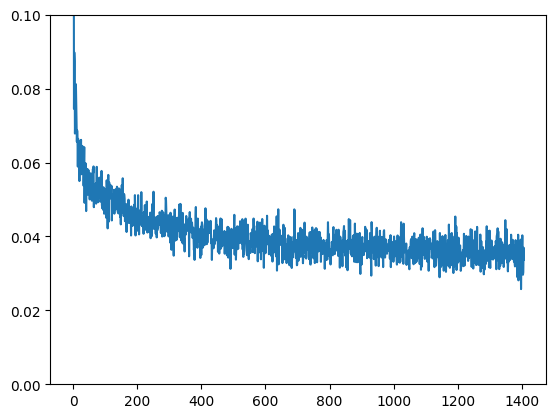

In [12]:
plt.plot(losses)
plt.ylim(0, 0.1)

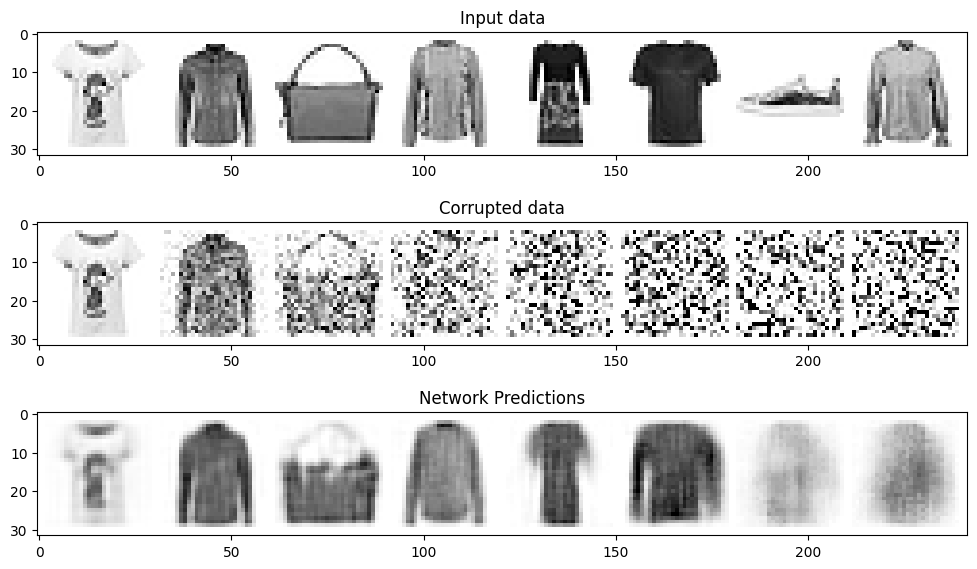

In [13]:
x, y = next(iter(train_loader))
x = x[:8]

noise_level = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt_image(x, noise_level)

with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

  0%|          | 0/40 [00:00<?, ?it/s]

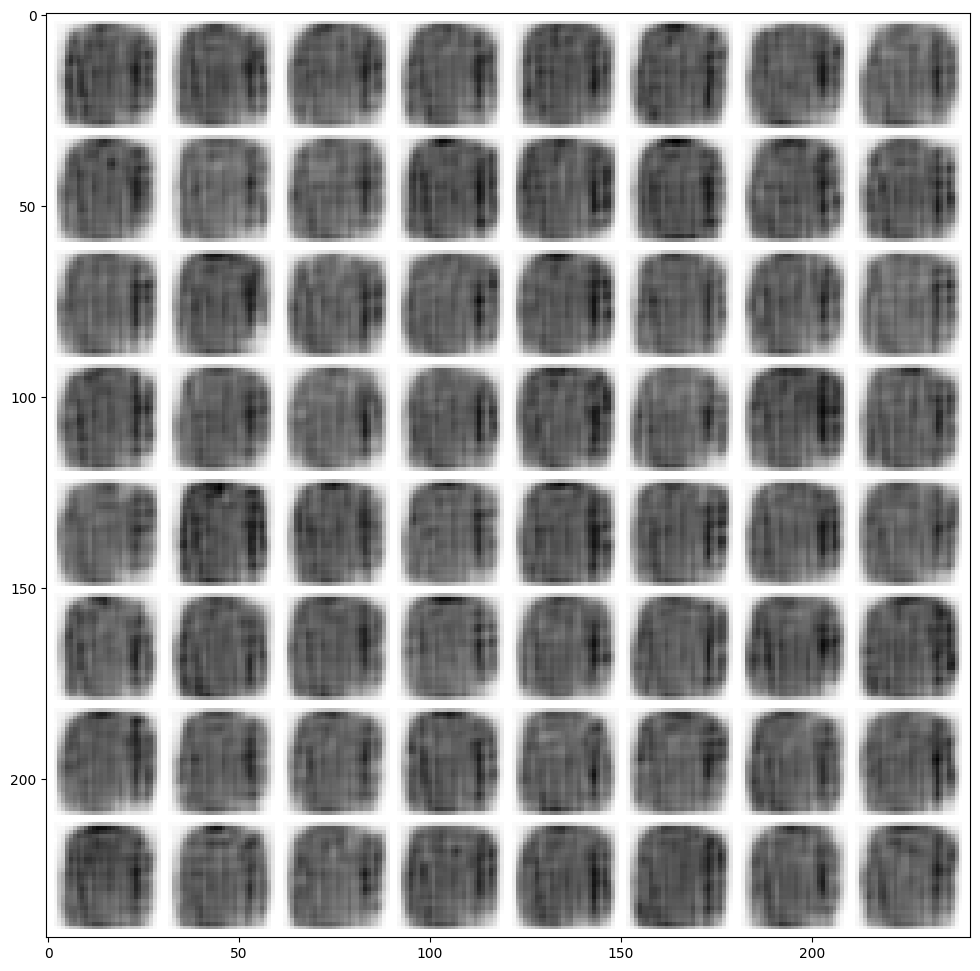

In [14]:
sample_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in tqdm(range(sample_steps)):
    noise_level = 1 - (i / sample_steps)
    noise_amount = torch.ones((x.shape[0],)).to(device) * noise_level
    with torch.no_grad():
        pred = net(corrupt_image(x, noise_amount))
    mix_factor = 1 / (sample_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
plt.show()